In [10]:
import numpy as np
import matplotlib.pyplot as plt
# import random

from scipy.integrate import solve_ivp
import torch 

In [23]:
# Чтобы при вызове print или display после точки выводилось фиксированное число знаков

# np.set_printoptions(precision=5, suppress=True)

# Генерация наших данных

Начальные концентрации:        [0.16667 0.16667 0.16667 0.16667 0.16667 0.16667]
Сумма концентрций веществ:  0.9999999999999999
[0.00001 0.00155 0.00181 0.      0.     ]


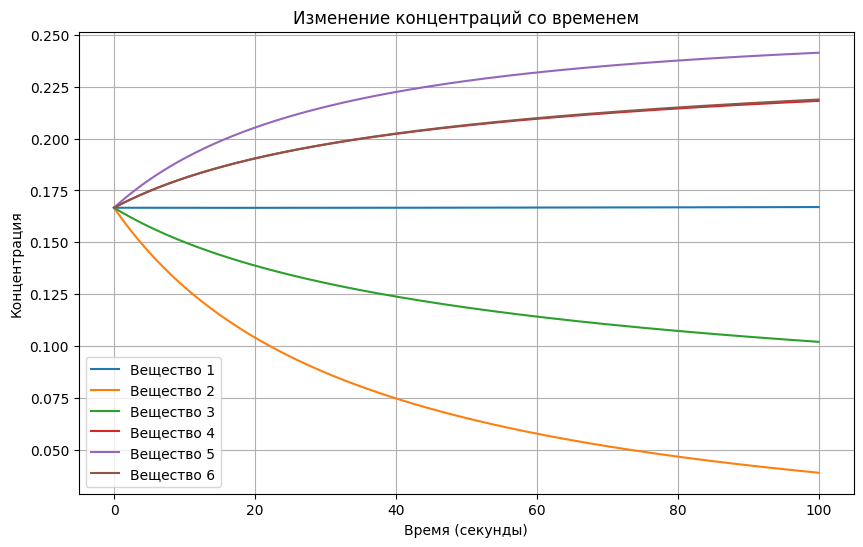

Концентрации после 100 секунд: [0.16699 0.03907 0.1021  0.21811 0.24131 0.21877]
Сумма концентрций веществ:  0.9863532425341756


In [24]:
# random.seed(1)

# Константы
N_REACTION = 5                                                                # реакций
N_SUBSTANCE = 6                                                               # веществ
A = np.array([100000000, 90000000, 85000000, 110000000, 95000000])
Ea= np.array([70000, 60000, 55000, 80000, 75000])
R = 8.314
temp = 300
vr_time = 100
H = 0.01
MATR = np.array([
    [-2, -1, 1, 1, 0, 0],
    [0, -2, 1, 0, 2, 0],
    [0, -1, -2, 1, 0, 1],
    [1, 0, 0, -2, 1, 0],
    [1, 0, 0, 0, -2, 1]
])

# Матрица порядков реакций
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
k = A * np.exp(-Ea / (R * temp)) * (temp**0.5)

# Переменные, будут заводиться отдельно
C = np.full(N_SUBSTANCE, 1 / N_SUBSTANCE)
print("Начальные концентрации:       ", C)
print("Сумма концентрций веществ: ", sum(C))

# Список для хранения концентраций на каждом шаге времени
concentration_history = [C.copy()]

print(np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)]))

def dC_dt(C):
    W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)])  # Скорость для каждой реакции
    dC = MATR.T @ W  # Изменение концентраций
    return dC

time_steps = int(vr_time / H)
for _ in range(time_steps):
    dC = dC_dt(C)
    C += dC * H
    concentration_history.append(C.copy())

concentration_history = np.array(concentration_history)

# Построение графика
time = np.linspace(0, vr_time, time_steps + 1)
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(time, concentration_history[:, i], label=f"Вещество {i+1}")

plt.title("Изменение концентраций со временем")
plt.xlabel("Время (секунды)")
plt.ylabel("Концентрация")
plt.legend()
plt.grid()
plt.show()

print(f"Концентрации после {vr_time} секунд: {C}")
print("Сумма концентрций веществ: ", sum(C))


# Генерация данных нашим подходом, но для CRNN-модели

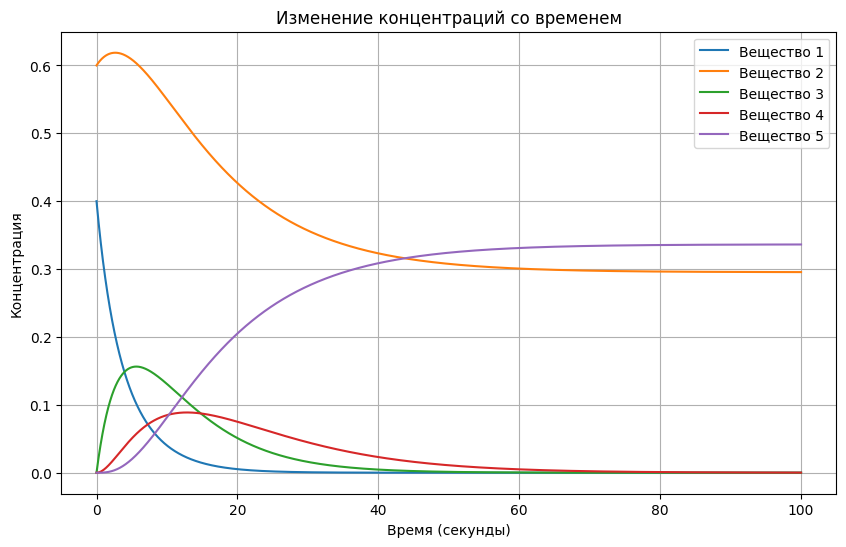

Начальные концентрации:        [0.4 0.6 0.  0.  0. ]
Сумма концентрций веществ:  1.0
Концентрации после 100 секунд: [0.      0.29556 0.      0.00017 0.33624]
Сумма концентрций веществ:  0.6319648320602071


In [25]:
# random.seed(1)

# Константы
N_REACTION = 4                                                               # реакций
N_SUBSTANCE = 5                                                              # веществ
vr_time = 100
H = 0.01
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

# Матрица порядков реакций
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)

# Переменные, будут заводиться отдельно
C0 = np.array([0.4, 0.6, 0, 0, 0])
C = np.array([0.4, 0.6, 0, 0, 0])

# Список для хранения концентраций на каждом шаге времени
concentration_history = [C.copy()]

def dC_dt(C):
    W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)])  # Скорость для каждой реакции
    dC = MATR.T @ W  # Изменение концентраций
    return dC

time_steps = int(vr_time / H)
for _ in range(time_steps):
    dC = dC_dt(C)
    C += dC * H
    concentration_history.append(C.copy())

concentration_history = np.array(concentration_history)

# Построение графика
time = np.linspace(0, vr_time, time_steps + 1)
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(time, concentration_history[:, i], label=f"Вещество {i+1}")

plt.title("Изменение концентраций со временем")
plt.xlabel("Время (секунды)")
plt.ylabel("Концентрация")
plt.legend()
plt.grid()
plt.show()

print("Начальные концентрации:       ", C0)
print("Сумма концентрций веществ: ", sum(C0))

print(f"Концентрации после {vr_time} секунд: {C}")
print("Сумма концентрций веществ: ", sum(C))


# Вариант генерации в CRNN-модели

In [26]:
def true_ode_func(t, y, k):
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : array-like
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : array-like
        Коэффициенты (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    dydt = np.zeros_like(y)
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

In [ ]:
# Константы
N_REACTION = 4                                                               # реакций
N_SUBSTANCE = 5                                                              # веществ
vr_time = 100                                                                # время прохождения реакций

k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)
C0 = np.array([0.4, 0.6, 0, 0, 0])                                           # начальные концентрации
C = np.array([0.4, 0.6, 0, 0, 0])

tspan = [0.0, vr_time]                                                       # временной промежуток
tsteps = np.linspace(tspan[0], tspan[1], 10)                                 # шаги по временному промежутку

sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        C,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

Начальные концентрации:        [0.4 0.6 0.  0.  0. ]
Сумма концентрций веществ:  1.0
[0.0, 10]


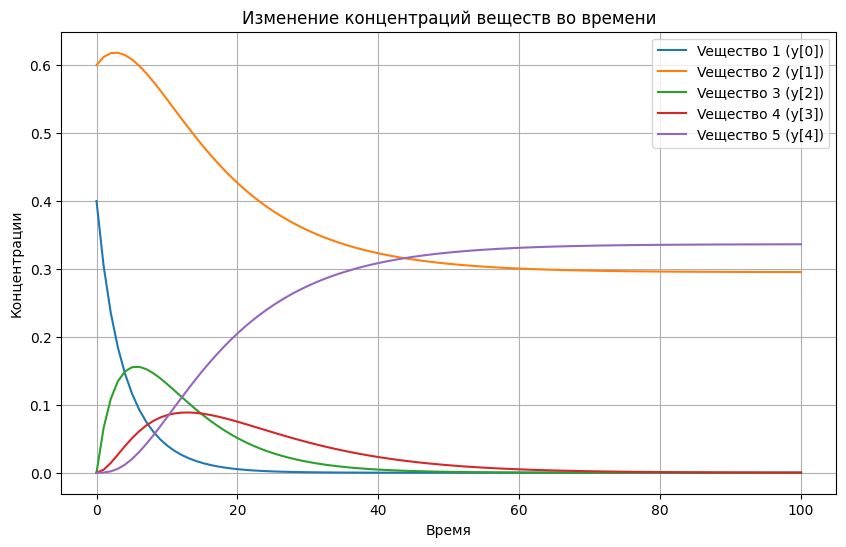

In [ ]:
# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Veщество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", C0)
print("Сумма концентраций веществ: ", sum(C0))